In [34]:
import pandas as pd
import numpy as np
import neptune
import matplotlib.pyplot as plt

In [35]:
# %% Train-Test split for time-series
stockprices = pd.read_csv("../data/AAPL_daily_stock_data.csv", index_col="Date")

test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train = stockprices[:train_size][["Close"]]
test = stockprices[train_size:][["Close"]]

train_size: 4363
test_size: 1090


In [36]:
## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i - N : i])
        y.append(data[i])

    return np.array(X), np.array(y)


In [37]:
#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)
    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse


def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [38]:
def calculate_perf_metrics(var):
    ### RMSE
    rmse = calculate_rmse(
        np.array(stockprices[train_size:]["Close"]),
        np.array(stockprices[train_size:][var]),
    )
    ### MAPE
    mape = calculate_mape(
        np.array(stockprices[train_size:]["Close"]),
        np.array(stockprices[train_size:][var]),
    )

    ## Log to Neptune
    run["RMSE"] = rmse
    run["MAPE (%)"] = mape

    return rmse, mape

In [39]:
def plot_stock_trend(var, cur_title, stockprices=stockprices):
    ax = stockprices[["Close", var, "200day"]].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")

    ## Log to Neptune
    run["Plot of Stock Predictions"].upload(
        neptune.types.File.as_image(ax.get_figure())
    )

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/sagarsolanki1/stock-price-prediction-ml/e/STOC-5
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/sagarsolanki1/stock-price-prediction-ml/e/STOC-5/metadata


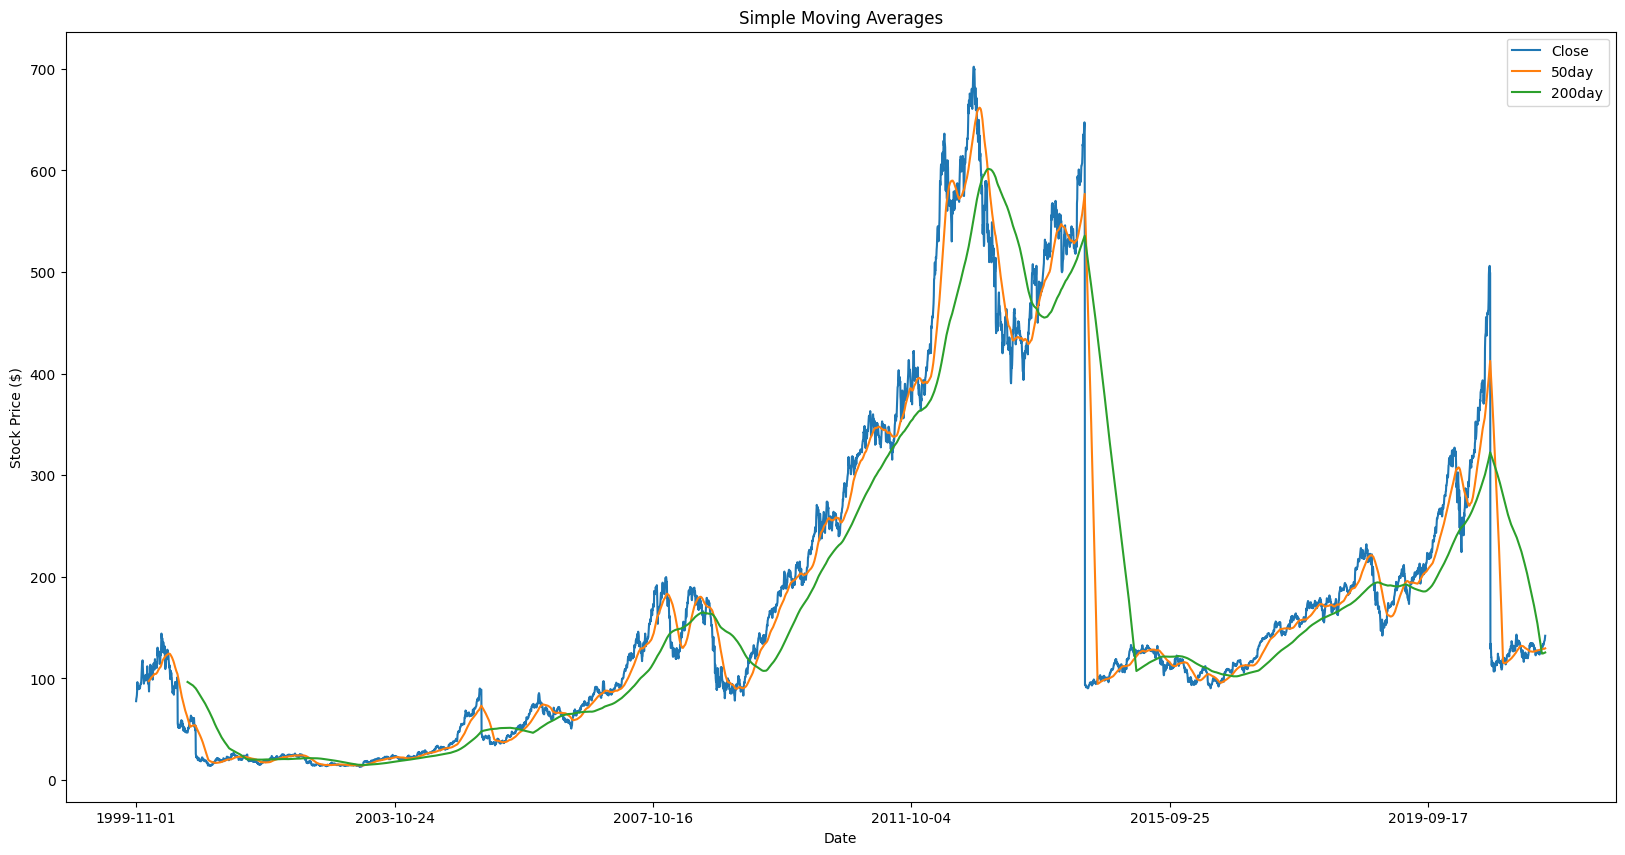

In [32]:
window_size = 50

# Initialize a Neptune run
run = neptune.init_run(
    project="sagarsolanki1/stock-price-prediction-ml",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxZmZlZGRmNy04OTYwLTQxMWYtYmY3YS1lMzM2ZGMwYzcyYTcifQ==",
)

window_var = f"{window_size}day"

stockprices[window_var] = stockprices["Close"].rolling(window_size).mean()

### Include a 200-day SMA for reference
stockprices["200day"] = stockprices["Close"].rolling(200).mean()

### Plot and performance metrics for SMA model
plot_stock_trend(var=window_var, cur_title="Simple Moving Averages")
rmse_sma, mape_sma = calculate_perf_metrics(var=window_var)

### Stop the run
run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/sagarsolanki1/stock-price-prediction-ml/e/STOC-6
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/sagarsolanki1/stock-price-prediction-ml/e/STOC-6/metadata


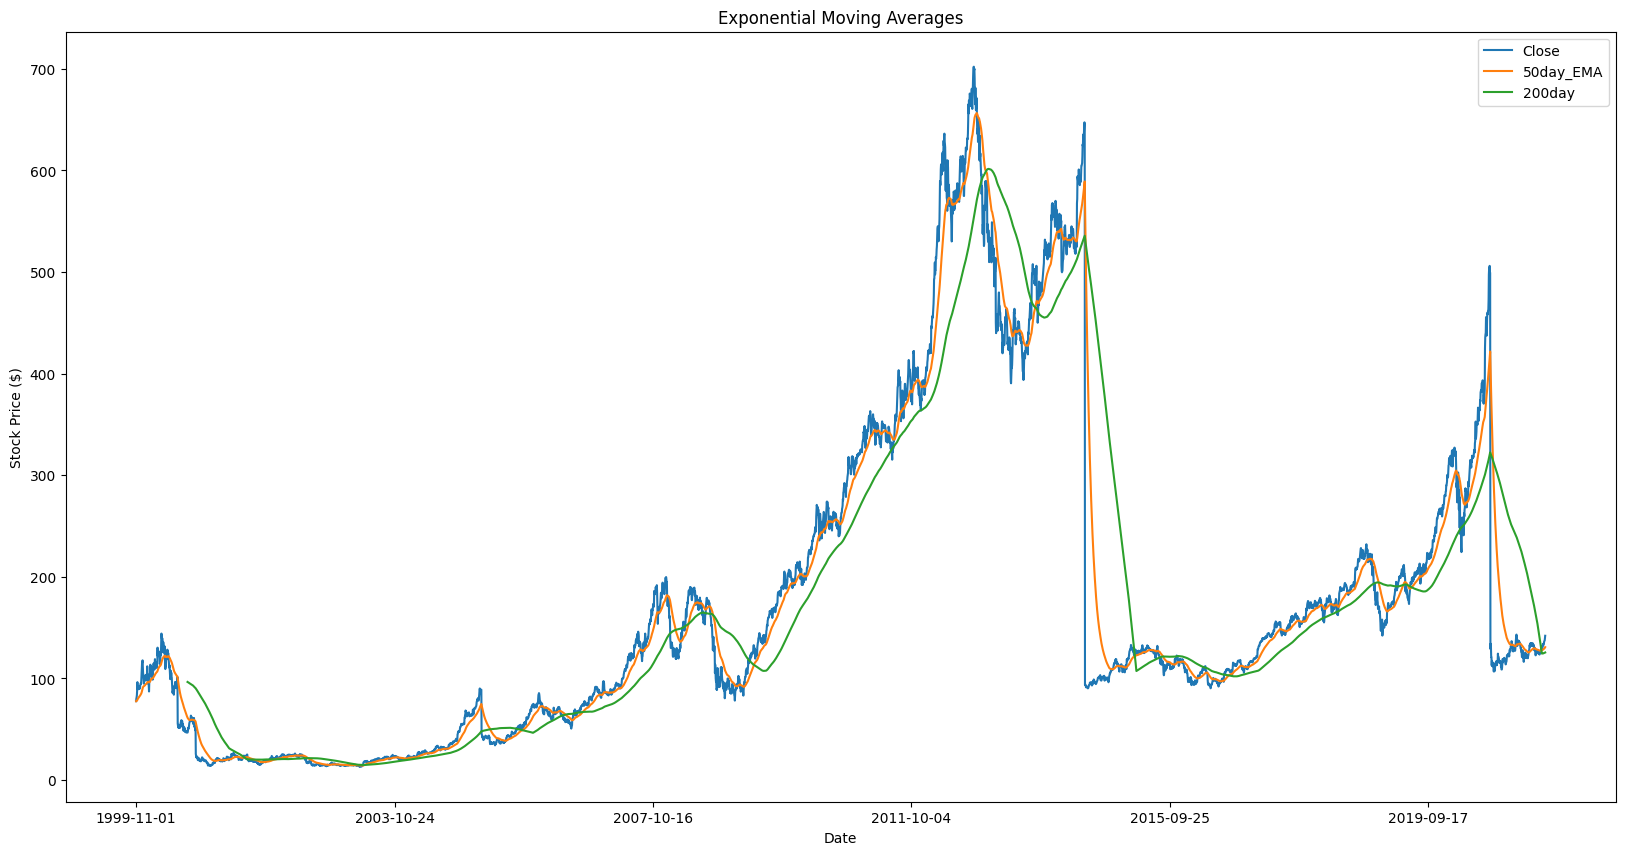

In [33]:
# Initialize a Neptune run
run = neptune.init_run(
    project="sagarsolanki1/stock-price-prediction-ml",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxZmZlZGRmNy04OTYwLTQxMWYtYmY3YS1lMzM2ZGMwYzcyYTcifQ==",
)

###### Exponential MA
window_ema_var = f"{window_var}_EMA"

# Calculate the 50-day exponentially weighted moving average
stockprices[window_ema_var] = (
    stockprices["Close"].ewm(span=window_size, adjust=False).mean()
)
stockprices["200day"] = stockprices["Close"].rolling(200).mean()

### Plot and performance metrics for EMA model
plot_stock_trend(
    var=window_ema_var, cur_title="Exponential Moving Averages")
rmse_ema, mape_ema = calculate_perf_metrics(var=window_ema_var)

### Stop the run
run.stop()